In [1]:
#
import findspark
findspark.init()
#
import pyspark
from pyspark.sql import functions as pfunc
from pyspark.sql import SQLContext
from pyspark.sql import Window, types
#
import re
import pandas as pd
import numpy as np
from pandas import DataFrame
from pyspark.sql.types import IntegerType
from pyspark.sql.types import FloatType
from pyspark.sql.functions import udf
from pyspark.sql.functions import *
from scipy.stats import kstest
from scipy import stats
#
from pyspark.ml.feature import Tokenizer
from pyspark.ml.feature import RegexTokenizer
#
#import org.apache.spark.ml.feature.NGram
from pyspark.ml.feature import NGram
#
from collections import Counter
#
from pyspark.ml.feature import NGram
#
from pyspark.ml.feature import NGram, CountVectorizer, VectorAssembler
from pyspark.ml import Pipeline
#
from pyspark.mllib.linalg import SparseVector, DenseVector
#
from pyspark.ml.feature import PCA
from pyspark.ml.linalg import Vectors
#
#
#
# Ugly workarround to increase spark.kryoserializer.buffer.max
# Only way in session to Run :
#        - treeAggregate at RowMatrix.scala:122 
#        - first at PCA.scala:43
#
sc = pyspark.SparkContext()
#conf = pyspark.SparkConf().setAll([('spark.kryoserializer.buffer.max','2047mb'),('spark.driver.memory','23g'),('spark.driver.maxResultSize','21g')])
conf = pyspark.SparkConf().setAll([('spark.kryoserializer.buffer.max','512mb')])
sc.stop()
sc = pyspark.SparkContext(conf=conf,appName="Notebook-FraudCanada-Model-NGrams-CountVectorizer-KL-KS-Entropy-Model-CleanData")
sqlContext = SQLContext(sc)
#
#
# Arguments
#
#import argparse
## Parse date_of execution
#parser = argparse.ArgumentParser()
#parser.add_argument("--datev1", help="Execution Date")
#args = parser.parse_args()
#if args.datev1:
#    processdate = args.datev1
# GENERAL PREPARATION SCRIPT
#
#  Date in format YYYYMMDD
#process_date = processdate
#if not process_date:
#    process_date = "20181231"
#
process_date="20190122"
#
input_file1_playback_fraud="hdfs:///data/staged/ott_dazn/fraud-canada-tokenizedwords/dt=*/*.json"
output_file1="hdfs:///data/staged/ott_dazn/advanced-model-data/fraud-notfraud-canada-tokenizedwords-ngrams-15-features-85/dt="+process_date
#
input_file2_playback_not_fraud="hdfs:///data/staged/ott_dazn/logs-archive-production/parquet/dt="+process_date+"/*.parquet"
output_file2="hdfs:///data/staged/ott_dazn/advanced-model-data/not-fraud-canada-tokenizedwords/dt="+process_date
input_file3=output_file2
#
input_file4="hdfs:///data/staged/ott_dazn/advanced-model-data/fraud-notfraud-canada-tokenizedwords-ngrams-15-features-85/dt="+process_date+"/*.*"
#
output_most_frequent_df="hdfs:///data/staged/ott_dazn/advanced-model-data/the-most-frequent-fraud-hash_message/dt="+process_date
#
#  FILTER Non-Fraud AND LABEL
from pyspark.sql import functions as F
#
#
df2= sqlContext.read.parquet(input_file2_playback_not_fraud)
df2.printSchema()
#
df3 = df2.filter(" (message LIKE '%\"Url\":\"https://isl-ca.dazn.com/misl/v2/Playback%') AND (message LIKE '%,\"Response\":{\"StatusCode\":200,\"ReasonPhrase\":\"OK\",%') AND ( ( (message LIKE '%&Format=MPEG-DASH&%' OR message LIKE '%&Format=M3U&%') ) OR (message NOT LIKE '%\"User-Agent\":\"Mozilla/5.0,(Macintosh; Intel Mac OS X 10_12_6),AppleWebKit/605.1.75,(KHTML, like Gecko),Version/11.1.2,Safari/605.1.75\"},%')   )  ")
df3.printSchema()
df4 = df3.withColumn("messagecut", expr("substring(message, locate('|Livesport.WebApi.Controllers.Playback.PlaybackV2Controller|',message)+60 , length(message)-1)"))
#
# val regexTokenizer = new RegexTokenizer().setInputCol("messagecut").setOutputCol("words").setPattern("\\w+|").setGaps(false)
#
regexTokenizer = RegexTokenizer(minTokenLength=1, gaps=False, pattern='\\w+|', inputCol="messagecut", outputCol="words", toLowercase=True)
#
tokenized = regexTokenizer.transform(df4)
tokenized.printSchema()
tokenized.coalesce(1).write.json(output_file2)
# Tokenize NON-Fraud-LABEL
# hash the message de-duplicate those records
notfraud_file=sqlContext.read.json(input_file3)
notfraud_file.printSchema()
#
notfraud_df=notfraud_file\
.filter("message IS NOT NULL").filter("words IS NOT NULL")\
.withColumn('fraud_label',lit(0).cast('int'))\
.withColumn('hash_message',F.sha2(col('message'),512)).groupby(col('hash_message'))\
.agg(F.first(col('fraud_label')).alias('fraud_label'),F.first(col('words')).alias('words'),F.first(col('message')).alias('message'))\
.persist(pyspark.StorageLevel.MEMORY_AND_DISK_2)
notfraud_df.printSchema()
#
df_notfraud_words = notfraud_df.filter("message IS NOT NULL").select(col('fraud_label'),col('hash_message'),col('words'))\
.persist(pyspark.StorageLevel.MEMORY_AND_DISK_2)
df_notfraud_words.printSchema()
#
# FILTER FRAUD AND LABEL 
# Join with Internal Curation Data in urltopredict staged folder
# hash the message de-duplicate those records
fraud_file=sqlContext.read.json(input_file1_playback_fraud)
fraud_file.printSchema()
#
fraud_df=fraud_file\
.filter("message IS NOT NULL").filter("words IS NOT NULL")\
.withColumn('fraud_label',lit(1).cast('int'))\
.withColumn('hash_message',F.sha2(col('message'),512)).groupby(col('hash_message'))\
.agg(F.first(col('fraud_label')).alias('fraud_label'),F.first(col('words')).alias('words'),F.first(col('message')).alias('message'))\
.persist(pyspark.StorageLevel.MEMORY_AND_DISK_2)
fraud_df.printSchema()
#
df_words = fraud_df.filter("message IS NOT NULL").select(col('fraud_label'),col('hash_message'),col('words'))\
.persist(pyspark.StorageLevel.MEMORY_AND_DISK_2)
df_words.printSchema()
#
result_fraud_nofraud_words = df_words.union(df_notfraud_words)
## Register Generic Functions
# -----------------------------------------------------------------------------
# Build ngrams 75 90 n=6 
# support : https://stackoverflow.com/questions/51473703/pyspark-ml-ngrams-countvectorizer-sorted-based-on-count-weights
# -----------------------------------------------------------------------------
def build_ngrams_part(inputCol="words", n=6):
    ngrams = [ 
        NGram(n=i, inputCol="words", outputCol="ngrams_{0}".format(i)) 
        for i in range(75, n + 1) ]
    vectorizers = [ 
        CountVectorizer(inputCol="ngrams_{0}".format(i), outputCol="ngramscounts_{0}".format(i)) 
        for i in range(75, n + 1) ]
    return Pipeline(stages=ngrams + vectorizers)
#    assembler = [VectorAssembler( inputCols=["ngramscounts_{0}".format(i) for i in range(1, n + 1)], outputCol="features" )]
#    return Pipeline(stages=ngrams + DenseVector(SparseVector(vectorizers).toArray()))
#
# 
# -----------------------------------------------------------------------------
#ngram = build_ngrams_part().fit(df_words)
#ngramDataFrame = ngram.transform(df_words)
#ngramDataFrame.coalesce(1).write.json(output_file1)
#
ngram = NGram(n=15, inputCol="words", outputCol="ngrams_15")
countvector = CountVectorizer(inputCol="ngrams_15", outputCol="ngramscounts_15")
# fit a CountVectorizerModel from the corpus.
countvModel = CountVectorizer(inputCol="words", outputCol="features_85", vocabSize=85, minDF=2.0)
# fit a PCA Dimensionality reduction into 75/15=5 components from ngramscounts_75 ## Too Heavy 1st PCA
pcaNgrams = PCA(k=5, inputCol="ngramscounts_15", outputCol="pcaweightngrams")
# fit a PCA Dimensionality reduction into 75/15=5 components from words
pcaWords = PCA(k=5, inputCol="features_85", outputCol="pcaweightwords")  ## Too Heavy 2nd PCA
#
ngram_fraud_DF = ngram.transform(result_fraud_nofraud_words)
ngram_vc_fraud_DF = countvector.fit(ngram_fraud_DF).transform(ngram_fraud_DF)\
.persist(pyspark.StorageLevel.MEMORY_AND_DISK_2)
ngram_vc_fraud_DF.printSchema()
#
#modelPCA_ngram_fraud_DF = pcaNgrams.fit(ngram_vc_fraud_DF).transform(ngram_vc_fraud_DF)\
#.persist(pyspark.StorageLevel.MEMORY_AND_DISK_2)
#modelPCA_ngram_fraud_DF.printSchema()
#
#result_ngrams_words_fraud_DF = countvModel.fit(modelPCA_ngram_fraud_DF).transform(modelPCA_ngram_fraud_DF)\
result_ngrams_words_fraud_DF = countvModel.fit(ngram_vc_fraud_DF).transform(ngram_vc_fraud_DF)\
.persist(pyspark.StorageLevel.MEMORY_AND_DISK_2)
result_ngrams_words_fraud_DF.printSchema()
#
result_ngrams_words_fraud_DF.coalesce(1).write.json(output_file1)
#
#  CALCULATE KL,KS COEF. Label Data
ngram15_fraud=sqlContext.read.json(input_file4).filter("fraud_label=0" )
ngram15_fraud.printSchema()
#
print("Calculation of standard_fraud_ngram - Start!")
#
# Obtain the most frequent word on each position 
# Compose the standard_fraud_ngram from the most common positions
# Calculate the standard_fraud_ngram
#
# https://stackoverflow.com/questions/35218882/find-maximum-row-per-group-in-spark-dataframe 
# Using struct ordering:
#from pyspark.sql.functions import struct
#
#(cnts
#  .groupBy("id_sa")
#  .agg(F.max(struct(col("cnt"), col("id_sb"))).alias("max"))
#  .select(col("id_sa"), col("max.id_sb")))
#
#Py4JJavaError: An error occurred while calling o3400.select.
#: org.apache.spark.sql.AnalysisException: cannot resolve '`ngrams`' given input columns: [mostfrequent];;
#'Project ['ngrams, mostfrequent#8033.count AS count#8037L]
#+- AnalysisBarrier
#      +- Aggregate [max(named_struct(count, count#8029L)) AS mostfrequent#8033]
#         +- Aggregate [ngrams#8016], [ngrams#8016, count(1) AS count#8029L]
#            +- Relation[fraud_label#8013L,hash_message#8014,message#8075,ngrams#8016,words#8017] json
#
####### OLD  ######
#.groupby(col('hash_message'))\
#.agg(F.first(col('features_75')).alias('features_75'),\
#     F.first(col('fraud_label')).alias('fraud_label'),\
#     F.first(col('ngrams_75')).alias('ngrams_75'),\
#     F.first(col('ngramscounts_75')).alias('ngramscounts_75'),F.first(col('words')).alias('words'))
####################
#
most_frequent_df=ngram15_fraud\
.withColumn("value_sum",F.explode("ngramscounts_15.values"))\
.groupBy("hash_message").agg(F.sum("value_sum").alias('count'))\
.persist(pyspark.StorageLevel.MEMORY_AND_DISK_2)
most_frequent_df.printSchema()
#
most_frequent_df.coalesce(1).write.json(output_most_frequent_df)
#
# The most Frequent would the the max
standard_fraud_ngram=most_frequent_df.orderBy(col('count').desc()).select(col('hash_message')).limit(1).toPandas()
#
print("Value Print: standard_fraud_ngram=")
print(standard_fraud_ngram)
#
print("Calculation of standard_fraud_ngram - Done!")
#
sc.stop()
#
print("Preparation of Data Done!")
#

root
 |-- metadata: struct (nullable = true)
 |    |-- beat: string (nullable = true)
 |    |-- type: string (nullable = true)
 |-- logzio_id: string (nullable = true)
 |-- awsRegion: string (nullable = true)
 |-- beat: struct (nullable = true)
 |    |-- hostname: string (nullable = true)
 |    |-- name: string (nullable = true)
 |    |-- version: string (nullable = true)
 |-- correlationId: string (nullable = true)
 |-- function_version: string (nullable = true)
 |-- host: struct (nullable = true)
 |    |-- name: string (nullable = true)
 |-- hostname: string (nullable = true)
 |-- id: string (nullable = true)
 |-- input_type: string (nullable = true)
 |-- invoked_function_arn: string (nullable = true)
 |-- it: string (nullable = true)
 |-- level: long (nullable = true)
 |-- logGroup: string (nullable = true)
 |-- logStream: string (nullable = true)
 |-- logzio_codec: string (nullable = true)
 |-- message: string (nullable = true)
 |-- messageType: string (nullable = true)
 |-- msg: s

root
 |-- hash_message: string (nullable = true)
 |-- count: double (nullable = true)

Value Print: standard_fraud_ngram=
                                        hash_message
0  deb7454c80749f06dc2cfc384c4b59fdb891965dbf1432...
Calculation of standard_fraud_ngram - Done!
Preparation of Data Done!


In [2]:
sc.stop()

In [5]:
#
import findspark
findspark.init()
#
import pyspark
from pyspark.sql import functions as pfunc
from pyspark.sql import SQLContext
from pyspark.sql import Window, types
#
import re
import pandas as pd
import numpy as np
from pandas import DataFrame
from pyspark.sql.types import IntegerType
from pyspark.sql.types import FloatType
from pyspark.sql.functions import udf
from pyspark.sql.functions import *
from scipy.stats import kstest
from scipy import stats
#
from pyspark.ml.feature import Tokenizer
from pyspark.ml.feature import RegexTokenizer
#
#import org.apache.spark.ml.feature.NGram
from pyspark.ml.feature import NGram
#
from collections import Counter
#
from pyspark.ml.feature import NGram
#
from pyspark.ml.feature import NGram, CountVectorizer, VectorAssembler
from pyspark.ml import Pipeline
#
from pyspark.mllib.linalg import SparseVector, DenseVector
#
from pyspark.ml.feature import PCA
from pyspark.ml.linalg import Vectors
#
#  FILTER with PySpark SQL Functions F.
from pyspark.sql import functions as F
# FUNCTIONS
# 
##
## Register Generic UDF Functions
# -----------------------------------------------------------------------------
# KL : Kullback-Leibler Divergence
# KS : Kolmogorov-Smirnov ( Sample sizes can be different)
# -----------------------------------------------------------------------------    
## NGRAM hash_mesage KL from URL TO Default NGRAM KL
def func_kl_ngram_msg(var1,var_match):
    ##Making sure the analysis of has_message SHA_512 is linear.
    ##Making sure the analysis is over the words list on same size
    def KL(P,Q):
        epsilon = 0.00001
        P = P+epsilon
        Q = Q+epsilon
        divergence = np.sum(P*np.log(P/Q))
        return np.asscalar(divergence)
    ##Making sure the analysis ignore trash
    cleanvar=var1.strip('http://').strip('https://').strip('www.')
    len_var1=len(cleanvar)
    idx_var1=cleanvar[:4]# Use "root1" as baseline #cleanvar.split("/")[0]#cleanvar[:8]
    list_values1 = list(cleanvar)
    list_of_ord_values1 = [ord(char) for char in list_values1]
    values1 = np.asarray(list_of_ord_values1)
    # URLS with at least 4166 characters
    ## TODO : Complete this list with common Malware/phishing sites used in internal webtraffic
    list_values2 = var_match
    list_values2 += var_match
    ## Making sure the analysis start on the same webdomain name
    idx_var2 = list_values2.find(idx_var1)
    start_values2 = list_values2[idx_var2:(idx_var2+len_var1)]
    list_values2 = list(start_values2+list_values2)
    list_values2 = list_values2[:len_var1]
    list_of_ord_values2 = [ord(char) for char in list_values2]
    values2 = np.asarray(list_of_ord_values2)
    return KL(values1,values2)
# -----------------------------------------------------------------------------
# -----------------------------------------------------------------------------
## NGRAM hash_message "Kolmogorov-Smirnov test KS pvalue= ks_2samp function8.
def func_ks_ngram_msg(var1,var_match):
    ##Making sure the analysis of has_message SHA_512 is linear.
    ##Making sure the analysis is over the words list on same size
    cleanvar=var1.strip('http://').strip('https://').strip('www.')
    len_var1=len(cleanvar)
    idx_var1=cleanvar[:4]# Use "root1" as baseline #cleanvar.split("/")[0]#cleanvar[:8]
    list_values1 = list(cleanvar)
    list_of_ord_values1 = [ord(char) for char in list_values1]
    values1 = np.asarray(list_of_ord_values1)
    values1= np.sort(values1)
    # URLS with up to least 4166 characters
    list_values2 = var_match
    list_values2 += var_match
    ## Making sure the analysis start on the same messgae
    idx_var2 = list_values2.find(idx_var1)
    start_values2 = list_values2[idx_var2:(idx_var2+len_var1)]
    list_values2 = list(start_values2+list_values2)
    list_values2 = list_values2[:len_var1]
    list_of_ord_values2 = [ord(char) for char in list_values2]
    values2 = np.asarray(list_of_ord_values2)
    values2=np.sort(values2)
    (Darray,pvalue)=stats.ks_2samp(values1, values2)
    return np.asscalar(pvalue)
# -----------------------------------------------------------------------------
# -----------------------------------------------------------------------------
## Entropy TO hash_message function3.
def func_entropy_ngram_msg(var1,var_match):
    ##Making sure the analysis of has_message SHA_512 is linear.
    ##Making sure the analysis is over the words list ignore size
    #
    cleanvar=var1.strip('http://').strip('https://').strip('www.')
    len_var1=len(cleanvar)
    idx_var1=cleanvar[:4]# Use "root1" as baseline #cleanvar.split("/")[0]#cleanvar[:8]
    list_values1 = list(cleanvar)
    list_of_ord_values1 = [ord(char) for char in list_values1]
    values1 = np.asarray(list_of_ord_values1)
    # URLS with at least 4166 characters
    ## TODO : Complete this list with an NGRAM search
    list_values2 = var_match
    list_values2 += var_match
    ## Making sure the analysis start on point
    idx_var2 = list_values2.find(idx_var1)
    start_values2 = list_values2[idx_var2:(idx_var2+len_var1)]
    list_values2 = list(start_values2+list_values2)
    list_values2 = list_values2[:len_var1]
    list_of_ord_values2 = [ord(char) for char in list_values2]
    values2 = np.asarray(list_of_ord_values2)
    pvalue=stats.entropy(values1, values2)
    scalar_pvalue=np.asscalar(pvalue)
    return scalar_pvalue
# -----------------------------------------------------------------------------
# -----------------------------------------------------------------------------
#
# -----------------------------------------------------------------------------
# -----------------------------------------------------------------------------
func_kl_ngram_msg_udf = udf(func_kl_ngram_msg, FloatType())
func_ks_ngram_msg_udf = udf(func_ks_ngram_msg, FloatType())
func_entropy_ngram_msg_udf = udf(func_entropy_ngram_msg, FloatType())
#
# Arguments
#
import argparse
## Parse date_of execution
#parser = argparse.ArgumentParser()
#parser.add_argument("--datev1", help="Execution Date")
#args = parser.parse_args()
#if args.datev1:
#    processdate = args.datev1
# GENERAL PREPARATION SCRIPT
#
#  Date in format YYYYMMDD
#process_date = processdate
#if not process_date:
#    process_date = "20181231"
#
process_date="20190122"
#
#
sc = pyspark.SparkContext()
#conf = pyspark.SparkConf().setAll([('spark.kryoserializer.buffer.max','2047mb'),('spark.driver.memory','23g'),('spark.driver.maxResultSize','21g')])
conf = pyspark.SparkConf().setAll([('spark.kryoserializer.buffer.max','512mb')])
sc.stop()
sc.stop()
sc = pyspark.SparkContext(conf=conf,appName="Notebook-FraudCanada-Model-NGrams-CountVectorizer-KL-KS-Entropy-Model-Labeling")
sqlContext = SQLContext(sc)
# Clean up the cluster just in case
h2o.remove_all()
#
input_most_frequent_df="hdfs:///data/staged/ott_dazn/advanced-model-data/the-most-frequent-fraud-hash_message/dt="+process_date
input_fraud="hdfs:///data/staged/ott_dazn/advanced-model-data/fraud-notfraud-canada-tokenizedwords-ngrams-15-features-85/dt="+process_date
#
input_file1="hdfs:///data/staged/ott_dazn/advanced-model-data/fraud-notfraud-canada-tokenizedwords-ngrams-15-features-85/dt="+process_date
output_file1="hdfs:///data/staged/ott_dazn/advanced-model-data/label-fraud-notfraud-data-model/dt="+process_date
preserve_training_output_file="hdfs:///data/staged/ott_dazn/advanced-model-data/preserve-training-output-automl-clean/dt="+process_date
#
# The most Frequent would the ones with the max frequency of NGrams85 tokens
pd.options.display.max_colwidth = 512
#
standard_fraud_ngram=sqlContext.read.json(input_most_frequent_df)\
.orderBy(col('count').desc()).select(col('hash_message')).limit(1).toPandas()['hash_message'][0]
print("Value UDF : standard_fraud_ngram=")
print(standard_fraud_ngram)
#
# Select Tokens/words form the max frequency of NGrams85 tokens hash_message
standard_fraud_ngram_words=sqlContext.read.json(input_fraud)
standard_fraud_ngram_words.printSchema()
#
standard_words_search=standard_fraud_ngram_words\
.withColumn('fraud_master_hash',lit(standard_fraud_ngram).cast('string'))\
.filter(" hash_message=fraud_master_hash ")
standard_words_search.printSchema()
#
standard_words=standard_words_search\
.withColumn('words_conc',F.concat_ws('',col('words')).cast('string'))\
.select(col('words_conc')).limit(1).toPandas()['words_conc'][0] 
# Working now! 
# Needs to be bigger than message twice should be tested!
#   Py4JJavaError: An error occurred while calling z:org.apache.spark.sql.functions.lit.
#      : java.lang.RuntimeException: Unsupported literal type class java.util.HashMap 
# {0=root15c466c8e6e8f9d17adb73426cd55c70f72b9f18e39e3455c9043a18b86b122b6requestmethodgeturlhttpsislcadazncommislv2playbackassetidfg5oon8sl71n1nfwuegbo8npgeventidarticleidfg5oon8sl71n1nfwuegbo8npgformatmpegdashplayeriddaznf3874e050812a853securetruelanguagecodeenlatitudenulllongitudenullplatformandroidtvmanufacturernvidiamodelnullmtalanguagecodeenclientip50100225179headersuseragentmozilla50linuxandroid800shieldandroidtvbuildopr6170623010wvapplewebkit53736khtmllikegeckoversion40chrome710357899mobilesafari53736fev1420typeinresponsestatuscode200reasonphraseokduration47jwtvieweridc2ebc25d8085deviceid993bf365c72c4b0b9168c2ebc25d8085f3874e050812a853userstatusactivepaid}
#
print("Value UDF : standard_words=")
print(standard_fraud_ngram)
#
ngram15_fraud=sqlContext.read.json(input_file1)
ngram15_fraud.printSchema()
#
drop_phish_cols=['words','ngrams_15']
#
fraud_label_read_df=ngram15_fraud.filter("hash_message is not NULL")\
.withColumn('words_conc',F.concat_ws('',col('words')).cast('string'))\
    .drop(*drop_phish_cols)\
    .withColumn('kl_words',func_kl_ngram_msg_udf(col('words_conc'),lit(standard_words).cast('string')).cast('double'))\
    .withColumn('ks_words',func_ks_ngram_msg_udf(col('words_conc'),lit(standard_words).cast('string')).cast('double'))\
    .withColumn('entropy_words',func_entropy_ngram_msg_udf(col('words_conc'),lit(standard_words).cast('string')).cast('double'))\
    .persist(pyspark.StorageLevel.MEMORY_AND_DISK_2)
fraud_label_read_df.printSchema()
#
fraud_label_read_df.coalesce(1).write.json(output_file1)
#
fraud_label_read_df.unpersist()
#
sc.stop()
#
print("Model Data KL,KS, Entropy Done! NGrams Vectors Data Done!")
#

Value UDF : standard_fraud_ngram=
c9b49b5510dc0c1f48de5a2b9e2d94682902ea27525fec5d9c6cd176dd7bdb59e2ff6c21a6823ed83de3e19770eebb415589e71bdbc62ff7b1a7f1b69fbe5637
root
 |-- features_85: struct (nullable = true)
 |    |-- indices: array (nullable = true)
 |    |    |-- element: long (containsNull = true)
 |    |-- size: long (nullable = true)
 |    |-- type: long (nullable = true)
 |    |-- values: array (nullable = true)
 |    |    |-- element: double (containsNull = true)
 |-- fraud_label: long (nullable = true)
 |-- hash_message: string (nullable = true)
 |-- ngrams_15: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- ngramscounts_15: struct (nullable = true)
 |    |-- indices: array (nullable = true)
 |    |    |-- element: long (containsNull = true)
 |    |-- size: long (nullable = true)
 |    |-- type: long (nullable = true)
 |    |-- values: array (nullable = true)
 |    |    |-- element: double (containsNull = true)
 |-- words: array (nullable = true)

In [44]:
#
import findspark
findspark.init()
#
import pyspark
from pyspark.sql import functions as pfunc
from pyspark.sql import SQLContext
from pyspark.sql import Window, types
#
import re
import pandas as pd
import numpy as np
from pandas import DataFrame
from pyspark.sql.types import IntegerType
from pyspark.sql.types import FloatType
from pyspark.sql.functions import udf
from pyspark.sql.functions import *
from scipy.stats import kstest
from scipy import stats
#
from pyspark.ml.feature import Tokenizer
from pyspark.ml.feature import RegexTokenizer
#
#import org.apache.spark.ml.feature.NGram
from pyspark.ml.feature import NGram
#
from collections import Counter
#
from pyspark.ml.feature import NGram
#
from pyspark.ml.feature import NGram, CountVectorizer, VectorAssembler
from pyspark.ml import Pipeline
#
from pyspark.mllib.linalg import SparseVector, DenseVector
#
from pyspark.ml.feature import PCA
from pyspark.ml.linalg import Vectors
#
#  FILTER with PySpark SQL Functions F.
#
# Arguments
#
import argparse
## Parse date_of execution
#parser = argparse.ArgumentParser()
#parser.add_argument("--datev1", help="Execution Date")
#args = parser.parse_args()
#if args.datev1:
#    processdate = args.datev1
# GENERAL PREPARATION SCRIPT
#
#  Date in format YYYYMMDD
#process_date = processdate
#if not process_date:
#    process_date = "20181231"
#
process_date="20190122"
#
#
sc = pyspark.SparkContext()
#conf = pyspark.SparkConf().setAll([('spark.kryoserializer.buffer.max','2047mb'),('spark.driver.memory','23g'),('spark.driver.maxResultSize','21g')])
conf = pyspark.SparkConf().setAll([('spark.kryoserializer.buffer.max','512mb'),('spark.driver.memory','16g'),('spark.driver.maxResultSize','12g')])
sc.stop()
sc.stop()
sc = pyspark.SparkContext(conf=conf,appName="Notebook-FraudCanada-AUTOML-Model-NGrams-CountVectorizer-KL-KS-Entropy")
sqlContext = SQLContext(sc)
# Clean up the cluster just in case
h2o.remove_all()
#
input_most_frequent_df="hdfs:///data/staged/ott_dazn/advanced-model-data/the-most-frequent-fraud-hash_message/dt="+process_date
input_fraud="hdfs:///data/staged/ott_dazn/advanced-model-data/fraud-notfraud-canada-tokenizedwords-ngrams-15-features-85/dt="+process_date
#
input_file1="hdfs:///data/staged/ott_dazn/advanced-model-data/fraud-notfraud-canada-tokenizedwords-ngrams-15-features-85/dt="+process_date
output_file1="hdfs:///data/staged/ott_dazn/advanced-model-data/label-fraud-notfraud-data-model/dt="+process_date
preserve_training_input_file="hdfs:///data/staged/ott_dazn/advanced-model-data/preserve-training-output-automl-clean/dt="+process_date
#
import h2o
from h2o.automl import H2OAutoML
#
import subprocess
subprocess.run('unset http_proxy', shell=True)
#
# Start an H2O virtual cluster that uses 6 gigs of RAM and 6 cores
h2o.init(ip="localhost",port=54321,max_mem_size = "6g", nthreads = 6) 
#
#  TRAINING PROCESS
#
print("Start Training Model NGrams Vectors KS KL Entropty")
#
# Horrible code :: close your eyes, is ugly
#
fraud_label_read_file=sqlContext.read.json(output_file1)
fraud_label_read_file.printSchema()
#
fraud_label_read_df=fraud_label_read_file\
.select(col('hash_message').cast('string'),col('fraud_label').cast('int'),\
        col('kl_words').cast('double'), col('ks_words').cast('double'),col('entropy_words').cast('double'),\
        col('features_85.type').alias('features85_type').cast('long'),\
        col('features_85.size').alias('features85_size').cast('long'),\
        col('features_85.indices').alias('features85_indices'),\
        col('features_85.values').alias('features85_values'),\
        col('ngramscounts_15.type').alias('ngramscounts15_type').cast('long'),\
        col('ngramscounts_15.size').alias('ngramscounts15_size').cast('long'),\
        col('ngramscounts_15.indices').alias('ngramscounts15_indices'),\
        col('ngramscounts_15.values').alias('ngramscounts15_values'))\
.persist(pyspark.StorageLevel.MEMORY_AND_DISK_2)
fraud_label_read_df.printSchema()
#
# ABOVE ARE CASE ISSUES on struct Struct of features_85 and ngramscounts_15 
# Both cares conversion to DF valide type list
# Flat vars for each, individually and seperately from the original struct
#
# https://stackoverflow.com/questions/47401418/pyspark-conversion-to-array-types?rq=1 
#
#
fraud_fraud_label_read_df=fraud_label_read_df.filter("fraud_label=1")\
.persist(pyspark.StorageLevel.MEMORY_AND_DISK_2)
notfraud_fraud_label_read_df=fraud_label_read_df.filter("fraud_label=0")\
.persist(pyspark.StorageLevel.MEMORY_AND_DISK_2)
#
fraud_fraud_label_read_df.printSchema()
notfraud_fraud_label_read_df.printSchema()
#
drop_list_cols=['features85_indices','features85_values','ngramscounts15_indices','ngramscounts15_values']
#
fraud_label_read_list_df=fraud_fraud_label_read_df\
.drop(*drop_list_cols)\
.persist(pyspark.StorageLevel.MEMORY_AND_DISK_2)

#.withColumn('features85_list_indices',F.explode(fraud_fraud_label_read_df['features85_indices']))\
#.withColumn('features85_list_values',F.explode(fraud_fraud_label_read_df['features85_values']))\
#.withColumn('ngramscounts15_list_indices',F.explode(fraud_fraud_label_read_df['ngramscounts15_indices']))\
#.withColumn('ngramscounts15_list_values',F.explode(fraud_fraud_label_read_df['ngramscounts15_values']))\

fraud_label_read_list_df.printSchema()
#
notfraud_label_read_list_df=notfraud_fraud_label_read_df\
.drop(*drop_list_cols)\
.persist(pyspark.StorageLevel.MEMORY_AND_DISK_2)

#.withColumn('features85_list_indices',F.explode(notfraud_fraud_label_read_df['features85_indices']))\
#.withColumn('features85_list_values',F.explode(notfraud_fraud_label_read_df['features85_values']))\
#.withColumn('ngramscounts15_list_indices',F.explode(notfraud_fraud_label_read_df['ngramscounts15_indices']))\
#.withColumn('ngramscounts15_list_values',F.explode(notfraud_fraud_label_read_df['ngramscounts15_values']))\

notfraud_label_read_list_df.printSchema()
#
fraud_label_train_pd=fraud_label_read_list_df.toPandas().head(1200)
fraud_label_test_pd=fraud_label_read_list_df.toPandas().head(200)
#
not_fraud_label_train_pd=notfraud_label_read_list_df.toPandas().head(5000)
not_fraud_label_test_pd=notfraud_label_read_list_df.toPandas().head(800)
#
fraud_label_train=h2o.H2OFrame(fraud_label_train_pd)
fraud_label_test=h2o.H2OFrame(fraud_label_test_pd)
not_fraud_label_train=h2o.H2OFrame(not_fraud_label_train_pd)
not_fraud_label_test=h2o.H2OFrame(not_fraud_label_test_pd)
#
#
###### TRAINING PROCESS ############
# RBIND "Merge" all of 3 internal ccrawl and phishtank with rbind .
# function merge() doesn't work if both H2O/dataframes have same variables
#
train = fraud_label_train.rbind(not_fraud_label_train)
test = fraud_label_test.rbind(not_fraud_label_test)
#
#
print("train")
print(train.head(10))
print("test")
print(test.head(10))
#
# Identify predictors and response
x = train.columns
#
# Fraud Label to be learned in the model from the atrributes of the ngram85 learned words
#
y= 'fraud_label'
x.remove(y)
#
# For binary classification, response should be a factor
#train[y] = train[y].asfactor()
#test[y] = test[y].asfactor()
#
# http://docs.h2o.ai/h2o/latest-stable/h2o-docs/automl.html
# Balance Classes to compensate unbalanced data
# Run AutoML for 25 base models (limited to 1 hour max runtime by default)
aml = H2OAutoML(max_models=25, seed=19, exclude_algos=["DRF","GLM"])
aml.train(x=x, y=y, training_frame=train)
#
preserve_training_output.write.json(preserve_training_output_file)
#
print("AutoML Modeling Done!")
#
sc.stop()

Checking whether there is an H2O instance running at http://localhost:54321. connected.


H2O cluster uptime:,5 days 8 hours 58 mins
H2O cluster timezone:,UTC
H2O data parsing timezone:,UTC
H2O cluster version:,3.22.0.1
H2O cluster version age:,3 months and 2 days
H2O cluster name:,H2O_from_python_siemanalyst_f03p4d
H2O cluster total nodes:,1
H2O cluster free memory:,4.934 Gb
H2O cluster total cores:,12
H2O cluster allowed cores:,12
H2O cluster status:,"locked, healthy"


Start Training Model NGrams Vectors KS KL Entropty
root
 |-- entropy_words: double (nullable = true)
 |-- features_85: struct (nullable = true)
 |    |-- indices: array (nullable = true)
 |    |    |-- element: long (containsNull = true)
 |    |-- size: long (nullable = true)
 |    |-- type: long (nullable = true)
 |    |-- values: array (nullable = true)
 |    |    |-- element: double (containsNull = true)
 |-- fraud_label: long (nullable = true)
 |-- hash_message: string (nullable = true)
 |-- kl_words: double (nullable = true)
 |-- ks_words: double (nullable = true)
 |-- ngramscounts_15: struct (nullable = true)
 |    |-- indices: array (nullable = true)
 |    |    |-- element: long (containsNull = true)
 |    |-- size: long (nullable = true)
 |    |-- type: long (nullable = true)
 |    |-- values: array (nullable = true)
 |    |    |-- element: double (containsNull = true)
 |-- words_conc: string (nullable = true)

root
 |-- hash_message: string (nullable = true)
 |-- fraud_label: 

hash_message,fraud_label,kl_words,ks_words,entropy_words,features85_type,features85_size,ngramscounts15_type,ngramscounts15_size
589ff83a30fa5d82563f0051bbd9f638d3dc7f102f8c78ab137c17b859e740de35348417e0deb2037cd0188c243c674100eb57f97450c4b942c9d3a1ef86a07b,1,4446.55,0.477263,0.0719711,0,85,0,262144
865fc00f8a94dd1c467c39753bfb2b18626f2827db85a05654caf048e657b6856afad3fef87873197e7f92e0ff760c8f04cd5484c910a037476643addfdb5c31,1,3287.65,0.947901,0.0696592,0,85,0,262144
a659ae2c8efbde6eb990b90acae3e02f644e44cd1a3a9aa6490632209641eb5714bb4b740ddcbe95e50b5cd319a8725634ffea38ae633fd6ab1f7114ad8c17bd,1,4169.68,0.52636,0.0708245,0,85,0,262144
d6d7bcd45dfa2fb6487352a532359f3f64afe250dacb422898ed9854af8992866bff17dac83f36763b46f2db2e0442fdf23fafdd58628636ca3395b6ef019a16,1,4538.96,0.210665,0.0757622,0,85,0,262144
da23c7d6b5dd13228bb9b8e5d3287463ca7b12fbc8a5c068ce2cf4ca3e7e89ca6990a4abfc69dcedd538ee916f64a8d5d0440d1ad309c9604efc9ad4074a81ed,1,4378.87,0.477263,0.077328,0,85,0,262144
980071f323752c9f7e987d2f657d244851b601c46ef50b2cd053d69ee9c3a7b413730fff5a68bea2dd9ada49d410f0c0f8165ad2a9096c2c419668df2b829de3,1,4222.18,0.523838,0.0740113,0,85,0,262144
e38e2712270ef1f79716537aa2816eaab104a20e17c94df57b49b787cda6f8e96794acf70b302c9708e9573dda18e402c7e996ea14e537e736001b12070d7542,1,4279.72,0.679739,0.0711178,0,85,0,262144
26f328150124298822fc4a0be849251c3d3545dcb2495c71dc92a60d1629ea641ec4d24c7004a3d579df61f5ba7197ffe6e88e3efaee93d226270372ee87d4b2,1,4375.28,0.386449,0.0745828,0,85,0,262144
2b8a2419e7f2c6fecb549146c3d66ab9cae9839005d8f848d39313e49b34d22c18c6eb7e20b3b0c5291d4ad0f7f2b329423816423f62a40a7dae70870c2b7f9f,1,4396.63,0.430514,0.0760735,0,85,0,262144
67d469882a190b2d6262a34bcca389d43799a46e823c51da3c685150a32c5779132915cfd6cc965db7d7f92639dd725dad1e29d2f69598d63cdf1402d2fa66b3,1,4478.26,0.307116,0.073295,0,85,0,262144



test


hash_message,fraud_label,kl_words,ks_words,entropy_words,features85_type,features85_size,ngramscounts15_type,ngramscounts15_size
589ff83a30fa5d82563f0051bbd9f638d3dc7f102f8c78ab137c17b859e740de35348417e0deb2037cd0188c243c674100eb57f97450c4b942c9d3a1ef86a07b,1,4446.55,0.477263,0.0719711,0,85,0,262144
865fc00f8a94dd1c467c39753bfb2b18626f2827db85a05654caf048e657b6856afad3fef87873197e7f92e0ff760c8f04cd5484c910a037476643addfdb5c31,1,3287.65,0.947901,0.0696592,0,85,0,262144
a659ae2c8efbde6eb990b90acae3e02f644e44cd1a3a9aa6490632209641eb5714bb4b740ddcbe95e50b5cd319a8725634ffea38ae633fd6ab1f7114ad8c17bd,1,4169.68,0.52636,0.0708245,0,85,0,262144
d6d7bcd45dfa2fb6487352a532359f3f64afe250dacb422898ed9854af8992866bff17dac83f36763b46f2db2e0442fdf23fafdd58628636ca3395b6ef019a16,1,4538.96,0.210665,0.0757622,0,85,0,262144
da23c7d6b5dd13228bb9b8e5d3287463ca7b12fbc8a5c068ce2cf4ca3e7e89ca6990a4abfc69dcedd538ee916f64a8d5d0440d1ad309c9604efc9ad4074a81ed,1,4378.87,0.477263,0.077328,0,85,0,262144
980071f323752c9f7e987d2f657d244851b601c46ef50b2cd053d69ee9c3a7b413730fff5a68bea2dd9ada49d410f0c0f8165ad2a9096c2c419668df2b829de3,1,4222.18,0.523838,0.0740113,0,85,0,262144
e38e2712270ef1f79716537aa2816eaab104a20e17c94df57b49b787cda6f8e96794acf70b302c9708e9573dda18e402c7e996ea14e537e736001b12070d7542,1,4279.72,0.679739,0.0711178,0,85,0,262144
26f328150124298822fc4a0be849251c3d3545dcb2495c71dc92a60d1629ea641ec4d24c7004a3d579df61f5ba7197ffe6e88e3efaee93d226270372ee87d4b2,1,4375.28,0.386449,0.0745828,0,85,0,262144
2b8a2419e7f2c6fecb549146c3d66ab9cae9839005d8f848d39313e49b34d22c18c6eb7e20b3b0c5291d4ad0f7f2b329423816423f62a40a7dae70870c2b7f9f,1,4396.63,0.430514,0.0760735,0,85,0,262144
67d469882a190b2d6262a34bcca389d43799a46e823c51da3c685150a32c5779132915cfd6cc965db7d7f92639dd725dad1e29d2f69598d63cdf1402d2fa66b3,1,4478.26,0.307116,0.073295,0,85,0,262144



AutoML progress: |████████████████████████████████████████████████████████| 100%


NameError: name 'preserve_training_output' is not defined

In [45]:
# View the AutoML Leaderboard
lb = aml.leaderboard
lb.head(rows=lb.nrows)  # Print all rows instead of default (10 rows)

model_id,mean_residual_deviance,rmse,mse,mae,rmsle
StackedEnsemble_AllModels_AutoML_20190128_230501,0.0216178,0.14703,0.0216178,0.0667004,0.105903
StackedEnsemble_BestOfFamily_AutoML_20190128_230501,0.0218711,0.147889,0.0218711,0.0648178,0.106422
GBM_grid_1_AutoML_20190128_230501_model_1,0.0231287,0.152081,0.0231287,0.0700761,0.110142
XGBoost_grid_1_AutoML_20190128_230501_model_4,0.0234031,0.152981,0.0234031,0.0679717,0.110572
XGBoost_grid_1_AutoML_20190128_230501_model_6,0.0245236,0.1566,0.0245236,0.0650828,0.112542
XGBoost_2_AutoML_20190128_230501,0.0247925,0.157456,0.0247925,0.071814,0.113481
XGBoost_3_AutoML_20190128_230501,0.0253672,0.159271,0.0253672,0.0733711,0.114375
GBM_3_AutoML_20190128_230501,0.0254382,0.159494,0.0254382,0.0726295,0.115642
XGBoost_1_AutoML_20190128_230501,0.02558,0.159937,0.02558,0.0712921,0.11525
XGBoost_grid_1_AutoML_20190128_230501_model_1,0.0256079,0.160025,0.0256079,0.0694607,0.115861


In [46]:
# The leader model is stored here
aml.leader

Model Details
H2OStackedEnsembleEstimator :  Stacked Ensemble
Model Key:  StackedEnsemble_AllModels_AutoML_20190128_230501
No model summary for this model


ModelMetricsRegressionGLM: stackedensemble
** Reported on train data. **

MSE: 0.006786966230005736
RMSE: 0.08238304576795966
MAE: 0.03876710293269622
RMSLE: 0.06397038037054179
R^2: 0.9564836524197928
Mean Residual Deviance: 0.006786966230005736
Null degrees of freedom: 5590
Residual degrees of freedom: 5581
Null deviance: 871.992487927015
Residual deviance: 37.94592819196207
AIC: -12025.901487553554

ModelMetricsRegressionGLM: stackedensemble
** Reported on validation data. **

MSE: 0.020963660327866344
RMSE: 0.1447883293911023
MAE: 0.06538868473030425
RMSLE: 0.10718682647036605
R^2: 0.8666605504019997
Mean Residual Deviance: 0.020963660327866344
Null degrees of freedom: 608
Residual degrees of freedom: 599
Null deviance: 95.74970038498333
Residual deviance: 12.766869139670604
AIC: -603.4964302517906

ModelMetricsRegressionGLM: s

In [47]:
# If you need to generate predictions on a test set, you can make
# predictions directly on the `"H2OAutoML"` object, or on the leader
# model object directly

#preds = aml.predict(test)
# or:
preds = aml.leader.predict(test)
print("test")
print(test.head(10))
print("prediction")
print(preds.head(10))

stackedensemble prediction progress: |████████████████████████████████████| 100%
test


hash_message,fraud_label,kl_words,ks_words,entropy_words,features85_type,features85_size,ngramscounts15_type,ngramscounts15_size
589ff83a30fa5d82563f0051bbd9f638d3dc7f102f8c78ab137c17b859e740de35348417e0deb2037cd0188c243c674100eb57f97450c4b942c9d3a1ef86a07b,1,4446.55,0.477263,0.0719711,0,85,0,262144
865fc00f8a94dd1c467c39753bfb2b18626f2827db85a05654caf048e657b6856afad3fef87873197e7f92e0ff760c8f04cd5484c910a037476643addfdb5c31,1,3287.65,0.947901,0.0696592,0,85,0,262144
a659ae2c8efbde6eb990b90acae3e02f644e44cd1a3a9aa6490632209641eb5714bb4b740ddcbe95e50b5cd319a8725634ffea38ae633fd6ab1f7114ad8c17bd,1,4169.68,0.52636,0.0708245,0,85,0,262144
d6d7bcd45dfa2fb6487352a532359f3f64afe250dacb422898ed9854af8992866bff17dac83f36763b46f2db2e0442fdf23fafdd58628636ca3395b6ef019a16,1,4538.96,0.210665,0.0757622,0,85,0,262144
da23c7d6b5dd13228bb9b8e5d3287463ca7b12fbc8a5c068ce2cf4ca3e7e89ca6990a4abfc69dcedd538ee916f64a8d5d0440d1ad309c9604efc9ad4074a81ed,1,4378.87,0.477263,0.077328,0,85,0,262144
980071f323752c9f7e987d2f657d244851b601c46ef50b2cd053d69ee9c3a7b413730fff5a68bea2dd9ada49d410f0c0f8165ad2a9096c2c419668df2b829de3,1,4222.18,0.523838,0.0740113,0,85,0,262144
e38e2712270ef1f79716537aa2816eaab104a20e17c94df57b49b787cda6f8e96794acf70b302c9708e9573dda18e402c7e996ea14e537e736001b12070d7542,1,4279.72,0.679739,0.0711178,0,85,0,262144
26f328150124298822fc4a0be849251c3d3545dcb2495c71dc92a60d1629ea641ec4d24c7004a3d579df61f5ba7197ffe6e88e3efaee93d226270372ee87d4b2,1,4375.28,0.386449,0.0745828,0,85,0,262144
2b8a2419e7f2c6fecb549146c3d66ab9cae9839005d8f848d39313e49b34d22c18c6eb7e20b3b0c5291d4ad0f7f2b329423816423f62a40a7dae70870c2b7f9f,1,4396.63,0.430514,0.0760735,0,85,0,262144
67d469882a190b2d6262a34bcca389d43799a46e823c51da3c685150a32c5779132915cfd6cc965db7d7f92639dd725dad1e29d2f69598d63cdf1402d2fa66b3,1,4478.26,0.307116,0.073295,0,85,0,262144



prediction


predict
1.04721
1.05317
0.973817
1.04858
1.05979
0.996341
0.998939
1.03872
1.05103
0.971315


In [48]:
# Get model ids for all models in the AutoML Leaderboard
model_ids = list(aml.leaderboard['model_id'].as_data_frame().iloc[:,0])

print(model_ids)
# Get the "All Models" Stacked Ensemble model
se = h2o.get_model([mid for mid in model_ids if "StackedEnsemble_AllModels" in mid][0])

# Get the Stacked Ensemble metalearner model
metalearner = h2o.get_model(aml.leader.metalearner()['name'])
metalearner.coef_norm()

['StackedEnsemble_AllModels_AutoML_20190128_230501', 'StackedEnsemble_BestOfFamily_AutoML_20190128_230501', 'GBM_grid_1_AutoML_20190128_230501_model_1', 'XGBoost_grid_1_AutoML_20190128_230501_model_4', 'XGBoost_grid_1_AutoML_20190128_230501_model_6', 'XGBoost_2_AutoML_20190128_230501', 'XGBoost_3_AutoML_20190128_230501', 'GBM_3_AutoML_20190128_230501', 'XGBoost_1_AutoML_20190128_230501', 'XGBoost_grid_1_AutoML_20190128_230501_model_1', 'GBM_4_AutoML_20190128_230501', 'GBM_2_AutoML_20190128_230501', 'XGBoost_grid_1_AutoML_20190128_230501_model_7', 'GBM_1_AutoML_20190128_230501', 'GBM_grid_1_AutoML_20190128_230501_model_2', 'XGBoost_grid_1_AutoML_20190128_230501_model_2', 'GBM_5_AutoML_20190128_230501', 'DeepLearning_grid_1_AutoML_20190128_230501_model_4', 'DeepLearning_grid_1_AutoML_20190128_230501_model_3', 'GBM_grid_1_AutoML_20190128_230501_model_3', 'GBM_grid_1_AutoML_20190128_230501_model_4', 'DeepLearning_grid_1_AutoML_20190128_230501_model_2', 'DeepLearning_1_AutoML_20190128_23050

{'DeepLearning_1_AutoML_20190128_230501': 0.0,
 'DeepLearning_grid_1_AutoML_20190128_230501_model_1': 0.0,
 'DeepLearning_grid_1_AutoML_20190128_230501_model_2': 0.0,
 'DeepLearning_grid_1_AutoML_20190128_230501_model_3': 1.410591865689174e-06,
 'DeepLearning_grid_1_AutoML_20190128_230501_model_4': 0.02828108584729825,
 'GBM_1_AutoML_20190128_230501': 0.0,
 'GBM_2_AutoML_20190128_230501': 0.0,
 'GBM_3_AutoML_20190128_230501': 7.984609444007188e-06,
 'GBM_4_AutoML_20190128_230501': 0.0,
 'GBM_5_AutoML_20190128_230501': 0.0,
 'GBM_grid_1_AutoML_20190128_230501_model_1': 0.16239689223861178,
 'GBM_grid_1_AutoML_20190128_230501_model_2': 0.0,
 'GBM_grid_1_AutoML_20190128_230501_model_3': 0.01807077683729992,
 'GBM_grid_1_AutoML_20190128_230501_model_4': 0.0,
 'Intercept': 0.19334644965122522,
 'XGBoost_1_AutoML_20190128_230501': 0.0,
 'XGBoost_2_AutoML_20190128_230501': 0.0,
 'XGBoost_3_AutoML_20190128_230501': 4.767972028486647e-06,
 'XGBoost_grid_1_AutoML_20190128_230501_model_1': 0.0,
 

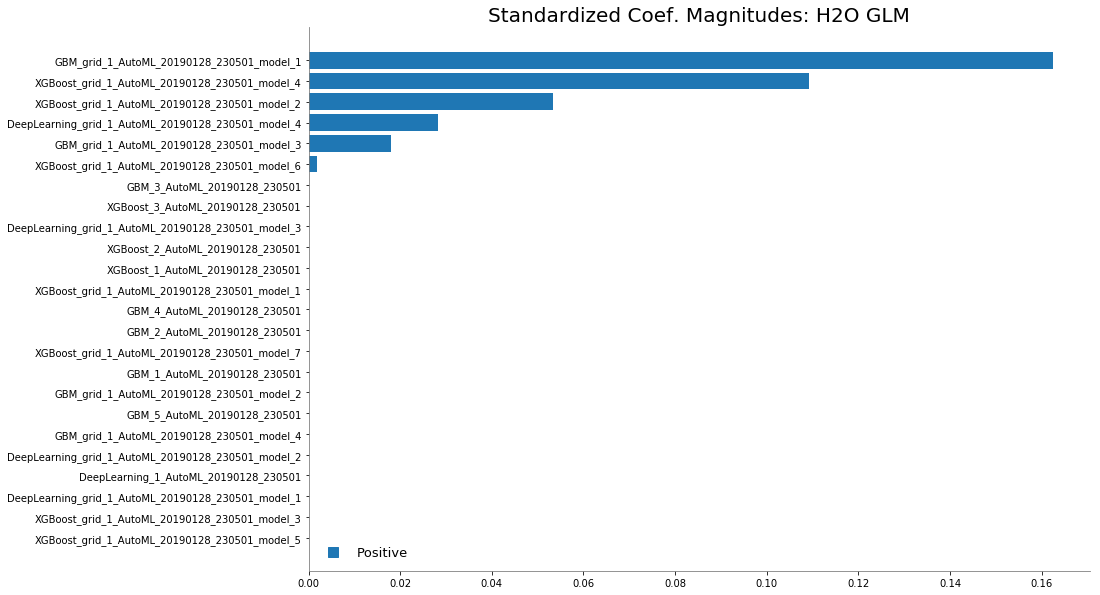

In [49]:
%matplotlib inline
metalearner.std_coef_plot()

In [50]:
aml.leader.download_mojo(path = "./product_model_bin/ngrams15_features85_m25/v4/mojo", get_genmodel_jar = True)

'/home/siemanalyst/projects/logs-archive-production/fraud-canada-tokenizedwords/product_model_bin/ngrams15_features85_m25/v4/mojo/StackedEnsemble_AllModels_AutoML_20190128_230501.zip'

In [51]:
sc.stop()

In [52]:
# If you need to generate predictions on a test set, you can make
# predictions directly on the `"H2OAutoML"` object, or on the leader
# model object directly

#preds = aml.predict(test)
# or:
preds = aml.leader.predict(test)
print("test")
print(test.tail(10))
print("prediction")
print(preds.tail(10))

stackedensemble prediction progress: |████████████████████████████████████| 100%
test


hash_message,fraud_label,kl_words,ks_words,entropy_words,features85_type,features85_size,ngramscounts15_type,ngramscounts15_size
28eb4e7f40b2576348154859edd355cd5d4c0f751bae54055dc3654b0a2df966e1274f09b5e9c09292ff4395df798ce9a02b5cfbf9071c9bc6765bf2812e9a35,0,5690.25,0.036261,0.0647111,0,85,0,262144
29c6c59805df1ca6a084f2f9f7f81b89958f8a5caf9299595ea9604ef72fa766efeff77e58e098f6a3778f1b11e0362f22d7ad79269e92b2f2a035127f761e2f,0,2752.83,0.363565,0.0654095,0,85,0,262144
29f957bbd4d764a06c90397f3b80784933af5fe29188b74ddb64290d19063e343af746e26e792b89c67fa6f5346d82339a21aa447e2f6e72aea37e8c815d9c72,0,4230.17,0.986841,0.0646723,0,85,0,262144
2a3f4b85be3eedb8be47c3f0ecd48ebca0a6936b663b90716795ae35184bacc9db2aa2620db40850bbb63224f8308e0b133932e88e9dce64377bce35631dd5d4,0,2027.88,0.142873,0.0659066,0,85,0,262144
2c9539bc4587613bbb2fd11aad658f5c59e605399e276294c15bdfc134419f7c354f8a3167768ec7dd07427e93366752f68f337473a34243c6f6f7124ca2d52f,0,5296.48,0.0642194,0.0678356,0,85,0,262144
2d98ad89fcf7dd6f8c06823eb6489bf01d5a68ef1b258d06cf3c437dd5b316b36e162fd384a0225d6426b8a0679bb26d76142b293e5f61aa42c83d04e062bafd,0,5443.37,0.0546268,0.06557,0,85,0,262144
2ded0a1badca5d2d9e2ceb1602d4f8b4c69503eaf351d3b26752eb671b1bb8e8d8a76b618826aa89bbfdd9e74360a0027f208fb2a500e255bc56c3eeb5d43c16,0,5168.13,0.0909001,0.0628464,0,85,0,262144
2df4c859f56269c915e963f386fb39754a8a8f550edfaef0e747c11ecdf8e456c9b5cdd909841c742711af59ce56a98fa32b1b6be46d87d133d50ff6d0bfdb6b,0,2643.15,0.280157,0.0692871,0,85,0,262144
370111fdd74149bef859c82a950aa357f6b03984c81a348e01874a5fe63156dd2eff2d83dd83350b175a5ab2a61606f9619625173fea69eb60b1b44cbbd654fa,0,1999.02,0.163965,0.0644722,0,85,0,262144
3947f05845930b1c0438a3dbcdce4c9133ff4c61e8b05f04a32f55d88bc412f8828cef778f938ce73312ad381e8852619a162569ea86c89268daf2ce1262b791,0,5885.44,0.0382891,0.0659859,0,85,0,262144



prediction


predict
-0.00733703
0.00838217
-0.0315408
-0.0121432
0.0102262
-0.00728912
-0.00738786
-0.00515054
-0.0106497
-0.00313791
